In [ ]:
# src/train.py
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import os

# Ensure directories exist
os.makedirs("models", exist_ok=True)
os.makedirs("results", exist_ok=True)

print(" Loading and preprocessing Fashion-MNIST...")

# Load dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

# Normalize and reshape
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0
x_train = x_train.reshape(-1, 28, 28, 1)
x_test = x_test.reshape(-1, 28, 28, 1)

# One-hot encode labels
y_train = tf.keras.utils.to_categorical(y_train, 10)
y_test = tf.keras.utils.to_categorical(y_test, 10)

print(f" Data loaded: {x_train.shape[0]} training, {x_test.shape[0]} test images")

# Build optimized CNN
model = models.Sequential([
    # Block 1
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
    layers.BatchNormalization(),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),

    # Block 2
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),

    # Classifier
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(10, activation='softmax')
])

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("\n Model summary:")
model.summary()

# Light data augmentation (enough to help, not slow down too much)
datagen = ImageDataGenerator(
    rotation_range=8,
    zoom_range=0.1,
    width_shift_range=0.08,
    height_shift_range=0.08
)
datagen.fit(x_train)

# Use fewer epochs + smarter callbacks
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_accuracy',
        patience=4,
        restore_best_weights=True,
        verbose=1
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=2,
        verbose=1
    )
]

print("\n⏳ Starting training (should take 5-15 mins on CPU)...")

# Train for max 25 epochs (usually stops earlier)
history = model.fit(
    datagen.flow(x_train, y_train, batch_size=128),
    steps_per_epoch=len(x_train) // 128,
    epochs=25,  # Reduced from 50 → 25
    validation_data=(x_test, y_test),
    callbacks=callbacks,
    verbose=1  # Show progress bar
)

# Save model and history
model.save("models/fashion_mnist_cnn.h5")
print("\n Model saved!")

# Save history
import pickle
with open('results/train_history.pkl', 'wb') as f:
    pickle.dump(history.history, f)

final_acc = history.history['val_accuracy'][-1]
print(f"\n Final Validation Accuracy: {final_acc:.4f} ({final_acc*100:.2f}%)")
print(" Run 'python src/evaluate.py' to generate confusion matrix and reports.")

🚀 Loading and preprocessing Fashion-MNIST...
✅ Data loaded: 60000 training, 10000 test images

🧠 Model summary:


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 26, 26, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 24, 24, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 12, 12, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 12, 12, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 10, 10, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 10, 10, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 8, 8, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 4, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 4, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │         5,130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 597,354 (2.28 MB)

 Trainable params: 596,138 (2.27 MB)

 Non-trainable params: 1,216 (4.75 KB)


⏳ Starting training (should take 5-15 mins on CPU)...
Epoch 1/25


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


468/468 ━━━━━━━━━━━━━━━━━━━━ 189s 397ms/step - accuracy: 0.6687 - loss: 0.9881 - val_accuracy: 0.6552 - val_loss: 0.8543 - learning_rate: 0.0010
Epoch 2/25
  1/468 ━━━━━━━━━━━━━━━━━━━━ 2:17 294ms/step - accuracy: 0.7344 - loss: 0.6244

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


468/468 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - accuracy: 0.7344 - loss: 0.6244 - val_accuracy: 0.6536 - val_loss: 0.8728 - learning_rate: 0.0010
Epoch 3/25
468/468 ━━━━━━━━━━━━━━━━━━━━ 178s 380ms/step - accuracy: 0.8096 - loss: 0.5032 - val_accuracy: 0.8701 - val_loss: 0.3513 - learning_rate: 0.0010
Epoch 4/25
468/468 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - accuracy: 0.8438 - loss: 0.3849 - val_accuracy: 0.8706 - val_loss: 0.3500 - learning_rate: 0.0010
Epoch 5/25
468/468 ━━━━━━━━━━━━━━━━━━━━ 194s 379ms/step - accuracy: 0.8396 - loss: 0.4316 - val_accuracy: 0.8889 - val_loss: 0.3181 - learning_rate: 0.0010
Epoch 6/25
468/468 ━━━━━━━━━━━━━━━━━━━━ 11s 22ms/step - accuracy: 0.8750 - loss: 0.3928 - val_accuracy: 0.8881 - val_loss: 0.3172 - learning_rate: 0.0010
Epoch 7/25
468/468 ━━━━━━━━━━━━━━━━━━━━ 193s 383ms/step - accuracy: 0.8560 - loss: 0.3952 - val_accuracy: 0.8906 - val_loss: 0.3061 - learning_rate: 0.0010
Epoch 8/25
468/468 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.8750 - loss: 0.3


✅ Model saved!

🎯 Final Validation Accuracy: 0.8840 (88.40%)
💡 Run 'python src/evaluate.py' to generate confusion matrix and reports.



Test Accuracy: 0.8906 (89.06%)
313/313 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step


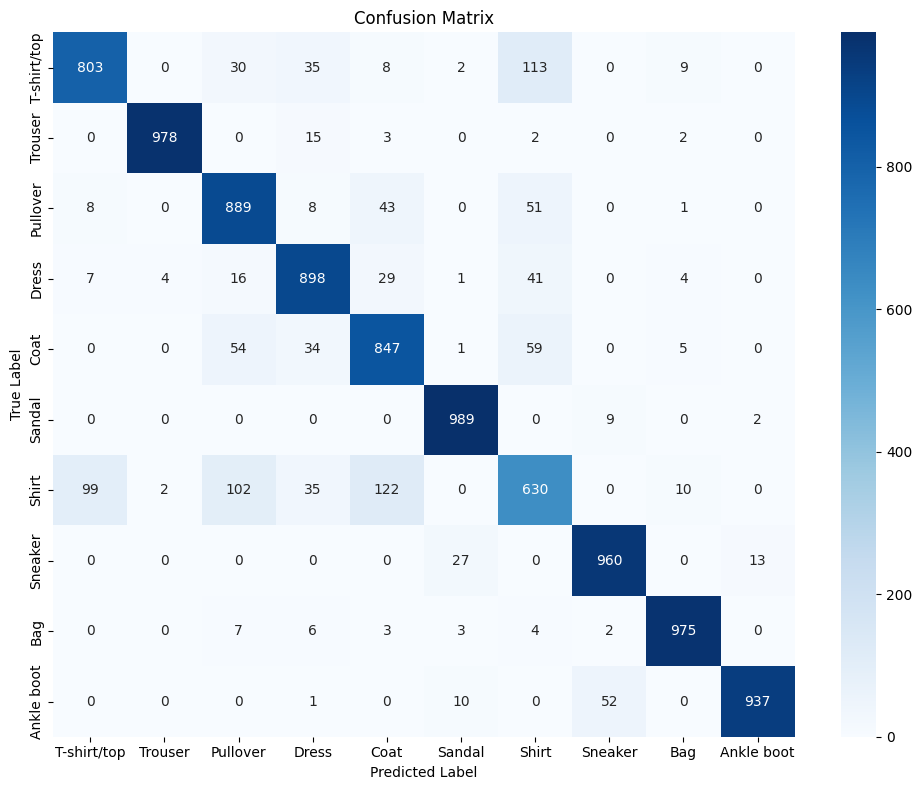


Per-Class Accuracy:
T-shirt/top    : 0.8030 (80.30%)
Trouser        : 0.9780 (97.80%)
Pullover       : 0.8890 (88.90%)
Dress          : 0.8980 (89.80%)
Coat           : 0.8470 (84.70%)
Sandal         : 0.9890 (98.90%)
Shirt          : 0.6300 (63.00%)
Sneaker        : 0.9600 (96.00%)
Bag            : 0.9750 (97.50%)
Ankle boot     : 0.9370 (93.70%)

Classification Report:
              precision    recall  f1-score   support

 T-shirt/top       0.88      0.80      0.84      1000
     Trouser       0.99      0.98      0.99      1000
    Pullover       0.81      0.89      0.85      1000
       Dress       0.87      0.90      0.88      1000
        Coat       0.80      0.85      0.82      1000
      Sandal       0.96      0.99      0.97      1000
       Shirt       0.70      0.63      0.66      1000
     Sneaker       0.94      0.96      0.95      1000
         Bag       0.97      0.97      0.97      1000
  Ankle boot       0.98      0.94      0.96      1000

    accuracy                 

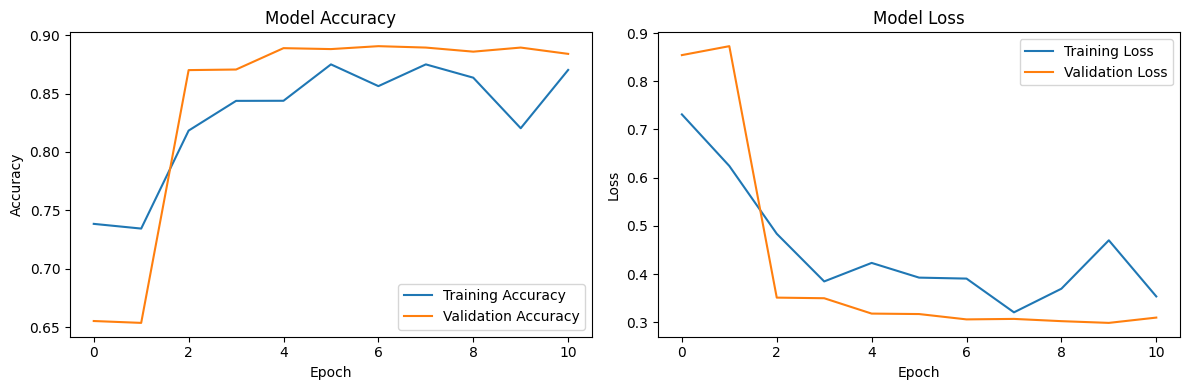


Evaluation complete! Results saved in 'results/' folder.


In [ ]:
# src/evaluate.py
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import pickle
import os

os.makedirs("results", exist_ok=True)

# Class names for Fashion-MNIST
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# Load data
(_, _), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
x_test = x_test.astype('float32') / 255.0
x_test = x_test.reshape(-1, 28, 28, 1)
y_test_labels = y_test  # Keep original labels for confusion matrix

# Load model
model = tf.keras.models.load_model("models/fashion_mnist_cnn.h5")

# Evaluate
test_loss, test_acc = model.evaluate(x_test, tf.keras.utils.to_categorical(y_test, 10), verbose=0)
print(f"\nTest Accuracy: {test_acc:.4f} ({test_acc*100:.2f}%)")

# Predictions
y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Confusion Matrix
cm = confusion_matrix(y_test_labels, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.savefig('results/confusion_matrix.png', dpi=150)
plt.show()

# Per-class accuracy
per_class_acc = cm.diagonal() / cm.sum(axis=1)
print("\nPer-Class Accuracy:")
for i, acc in enumerate(per_class_acc):
    print(f"{class_names[i]:<15}: {acc:.4f} ({acc*100:.2f}%)")

# Classification Report
report = classification_report(y_test_labels, y_pred_classes, target_names=class_names)
print("\nClassification Report:")
print(report)

# Save report to file
with open('results/classification_report.txt', 'w') as f:
    f.write(f"Test Accuracy: {test_acc:.4f}\n\n")
    f.write(report)

# Plot training history
if os.path.exists('results/train_history.pkl'):
    with open('results/train_history.pkl', 'rb') as f:
        history = pickle.load(f)

    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history['accuracy'], label='Training Accuracy')
    plt.plot(history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history['loss'], label='Training Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.savefig('results/training_history.png', dpi=150)
    plt.show()

print("\nEvaluation complete! Results saved in 'results/' folder.")


 Generating sample predictions plot...


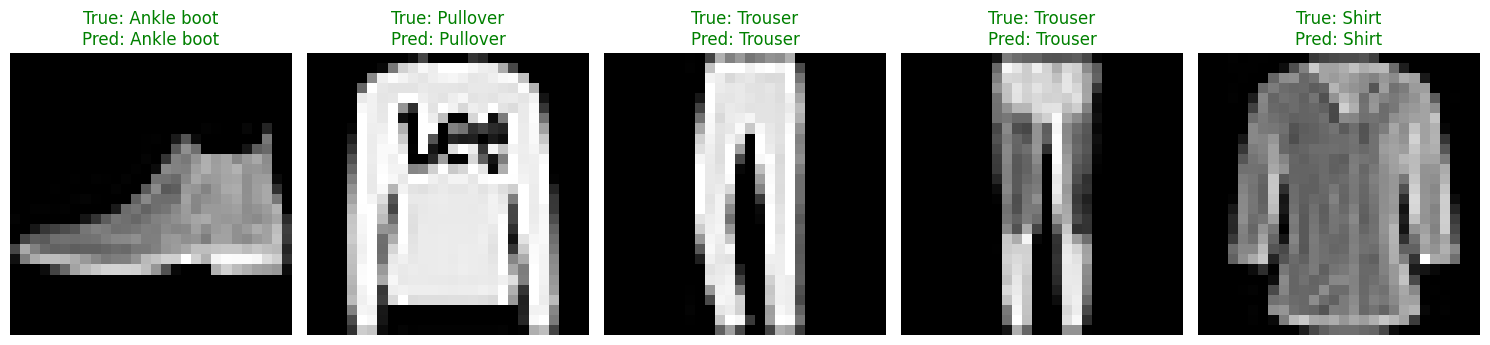

 Sample predictions saved to 'results/sample_predictions.png'


In [ ]:
# ===== SHOW 5 SAMPLE PREDICTIONS =====
print("\n Generating sample predictions plot...")

plt.figure(figsize=(15, 6))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    # x_test is already normalized and shaped (N, 28, 28, 1)
    plt.imshow(x_test[i].reshape(28, 28), cmap='gray')
    true_label = y_test_labels[i]  # This must be the original integer label
    pred_label = y_pred_classes[i]
    plt.title(
        f"True: {class_names[true_label]}\nPred: {class_names[pred_label]}",
        color='green' if true_label == pred_label else 'red'
    )
    plt.axis('off')

plt.tight_layout()
plt.savefig('results/sample_predictions.png', dpi=150, bbox_inches='tight')
plt.show()
print(" Sample predictions saved to 'results/sample_predictions.png'")